<a href="https://colab.research.google.com/github/OFFICIALNITIN/Colorizing/blob/main/Colorizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import files
files.upload()  # upload kaggle.json here


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"nitin2003","key":"5543a2c33aadeeac684c10fd55f2105d"}'}

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [10]:
!kaggle datasets download -d arnaud58/landscape-pictures
!unzip -q landscape-pictures.zip -d dataset


Dataset URL: https://www.kaggle.com/datasets/arnaud58/landscape-pictures
License(s): CC0-1.0


In [11]:

!pip install scikit-image


In [12]:

import os
import glob
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize


In [13]:

class LandscapeLABDataset(Dataset):
    def __init__(self, root_dir, image_size=(128, 128)):
        self.files = glob.glob(os.path.join(root_dir, "*.jpg"))
        self.size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(self.size),
            transforms.CenterCrop(self.size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        image_np = image.numpy().transpose(1, 2, 0)

        # Convert to LAB
        lab = rgb2lab(image_np)
        L = lab[:, :, 0] / 100.0
        ab = lab[:, :, 1:] / 128.0
        L = torch.tensor(L).unsqueeze(0).float()
        ab = torch.tensor(ab).permute(2, 0, 1).float()
        return L, ab


In [14]:

class ColorizationUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=2, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 2, 3, padding=1), nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [16]:

dataset = LandscapeLABDataset(root_dir="dataset", image_size=(128, 128))
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)


In [17]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ColorizationUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(3):  # You can increase this
    model.train()
    total_loss = 0
    for L, ab in train_loader:
        L, ab = L.to(device), ab.to(device)
        pred_ab = model(L)
        loss = criterion(pred_ab, ab)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")


Epoch 1: Loss = 0.0161
Epoch 2: Loss = 0.0152
Epoch 3: Loss = 0.0138


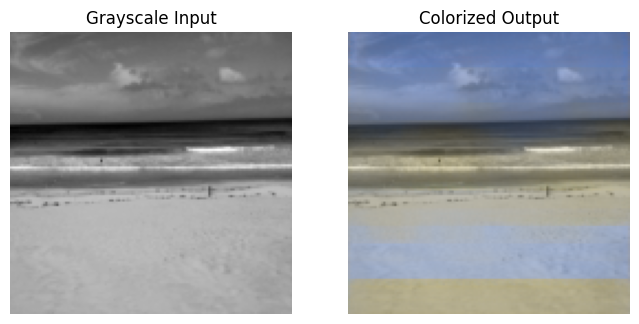

In [18]:
model.eval()
with torch.no_grad():
    L, ab = dataset[0]
    pred_ab = model(L.unsqueeze(0).to(device)).cpu().squeeze().numpy() * 128
    L_img = L.squeeze().numpy() * 100

    lab_img = np.zeros((128, 128, 3))
    lab_img[:, :, 0] = L_img
    lab_img[:, :, 1:] = pred_ab.transpose(1, 2, 0)
    rgb = lab2rgb(lab_img)

    # Display
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(L_img, cmap='gray')
    plt.title("Grayscale Input")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(rgb)
    plt.title("Colorized Output")
    plt.axis("off")
    plt.show()
